In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
sys.path.append('../')  

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

In [2]:
from test_data import experiment_data,add_noise,normalise_frobenius,normalise_minmax,create_data_2d
from numpy.linalg import matrix_rank, svd
from itertools import product
from utils import plot_result_jacobi
from error_bounds import *

In [57]:
def get_derivatives(u,dt,dx,fd_order,drop_endpoints=True,remove_endpoints=True):
    #Compute the derivatives
    ut_fd = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=drop_endpoints)._differentiate(u, t=dt)
    utx_fd = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=drop_endpoints)._differentiate(ut_fd, dx)
    ux_fd = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=drop_endpoints)._differentiate(u, dx)
    uxx_fd = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=drop_endpoints)._differentiate(u, dx) 

    if remove_endpoints:
        #Filter out the boundary values
        ut_fd= ut_fd[~np.isnan(ut_fd).all(axis=1)][:, ~np.isnan(ut_fd).all(axis=0)]
        utx_fd= utx_fd[~np.isnan(utx_fd).all(axis=1)][:, ~np.isnan(utx_fd).all(axis=0)]
        ux_fd= ux_fd[~np.isnan(ux_fd).all(axis=1)][:, ~np.isnan(ux_fd).all(axis=0)]
        uxx_fd= uxx_fd[~np.isnan(uxx_fd).all(axis=1)][:, ~np.isnan(uxx_fd).all(axis=0)]
    return ut_fd, utx_fd,ux_fd, uxx_fd

def drop_endpoints(func_fd,func_true):
    func_true = func_true[~np.isnan(func_fd).all(axis=1)][:, ~np.isnan(func_fd).all(axis=0)]
    func_fd= func_fd[~np.isnan(func_fd).all(axis=1)][:, ~np.isnan(func_fd).all(axis=0)]
    return func_fd,func_true

We want to get a threshold and error bound for analysing a analytic or polynomial PDE as unique. We can reuse the functions from the SFranco method.

### Easy examples: $u_1 = x^2 + t^2$ and $u_2 = exp(x-at)$

In [91]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-2, T_end=2, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
"""
#not unique
u = X**2 + T**2
ux = 2*X
ut = 2*T
utx = 0*T
uxx = 2*np.ones(X.shape)
"""

#not unqiue
u = np.exp(X-a*T)
ux = u
ut = -a*u
utx = -a*u
uxx = u
"""
#analytic unique
u=(X + T)*np.arccos(1/np.cosh(a*T))
ut = a*(T + X)*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2) + np.arccos(1/np.cosh(T*a))
ux = np.arccos(1/np.cosh(T*a))
utx = a*np.sinh(T*a)/(np.sqrt(1 - 1/np.cosh(T*a)**2)*np.cosh(T*a)**2)
uxx = np.zeros(X.shape)
"""
print(f"a {a}")
dt=t[1]-t[0]
dx=x[1]-x[0]

a -0.37280108435234505


#### Compare the error on finite differences on the Jacobian of $g = ( u | u_x)$

In [92]:
#Compute the derivatives
fd_order=8
ut_fd, utx_fd,ux_fd, uxx_fd = get_derivatives(u,dt,dx,fd_order,drop_endpoints=True,remove_endpoints=False)

#Filter out the boundary values
ut_fd,ut = drop_endpoints(ut_fd,ut)
utx_fd,utx = drop_endpoints(utx_fd,utx)
ux_fd,ux = drop_endpoints(ux_fd,ux)
uxx_fd,uxx = drop_endpoints(uxx_fd,uxx)

Compare the upper bounds for different derivatives and the Jacobian

Without noise

Lets calculate an upper bound for the different derivatives

In [93]:
eps=1e-15

bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(a**(fd_order+1)*u),Cxi=1.0,h=dt)
bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(u),Cxi=1.0,h=dx)
bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=infinity_norm(u),Cxi=1.0,h=dx)
bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=infinity_norm(ut),Cxi=1.0,h=dx)

print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")

 |ut_fd - ut| 	= 1.563e-12 <= 1.617e-13
 |ux_fd - ux| 	= 3.892e-09 <= 5.836e-09
 |uxx_fd - uxx|	= 7.783e-10 <= 1.167e-08
 |utx_fd - utx|	= 1.282e-09 <= 1.930e-09


Check wether upper bound is correct:
|JG-JG_fd|= 5.538e-11 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 7.511e-11 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 1.019e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 1.381e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 1.536e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 2.085e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 2.825e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 3.831e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 4.263e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 5.778e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 7.831e-10 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 1.062e-09 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 1.183e-09 <= 1.319e-08
Check wether upper bound is correct:
|JG-JG_fd|= 1.605e-09 <= 1.

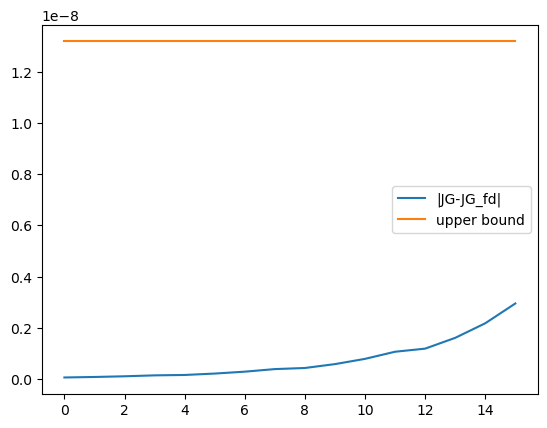

In [94]:
jacobians =[]
upperbounds=[]
for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)

        jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)
        nr_datapoints=1
        upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)

        jacobians.append(jacobian_diff)
        upperbounds.append(upperbound)

        print("Check wether upper bound is correct:")
        print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")

plt.plot(jacobians,label="|JG-JG_fd|")
plt.plot(upperbounds, label="upper bound")
plt.legend()
plt.show()

With noise

Noise level 0
 |ut_fd - ut| 	= 1.563e-12 <= 1.362e-13
 |ux_fd - ux| 	= 3.892e-09 <= 5.836e-09
 |uxx_fd - uxx|	= 7.783e-10 <= 1.167e-08
 |utx_fd - utx|	= 1.282e-09 <= 1.929e-09
Upper bound 1.319e-08


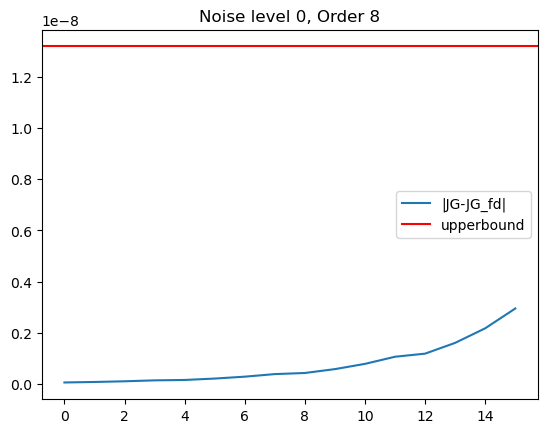

Noise level 1e-10
 |ut_fd - ut| 	= 2.851e-07 <= 5.556e-07
 |ux_fd - ux| 	= 2.583e-07 <= 4.503e-07
 |uxx_fd - uxx|	= 8.593e-06 <= 1.361e-05
 |utx_fd - utx|	= 3.600e-06 <= 1.135e-05
Upper bound 1.773e-05


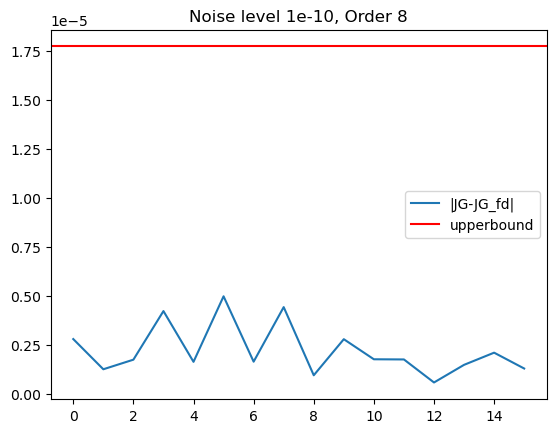

Noise level 1e-09
 |ut_fd - ut| 	= 2.662e-06 <= 4.624e-06
 |ux_fd - ux| 	= 2.295e-06 <= 3.705e-06
 |uxx_fd - uxx|	= 6.908e-05 <= 1.132e-04
 |utx_fd - utx|	= 3.311e-05 <= 9.442e-05
Upper bound 1.475e-04


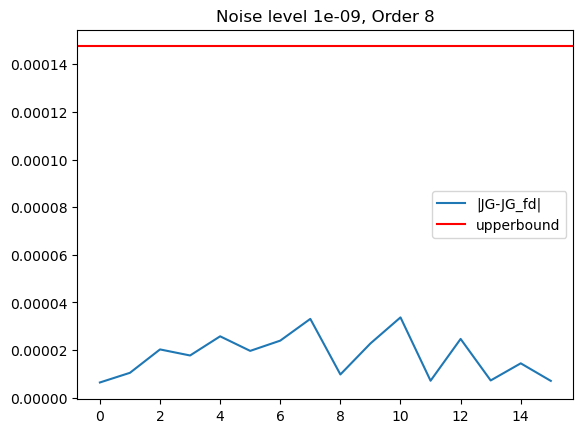

Noise level 1e-08
 |ut_fd - ut| 	= 2.975e-05 <= 5.517e-05
 |ux_fd - ux| 	= 2.227e-05 <= 4.414e-05
 |uxx_fd - uxx|	= 7.168e-04 <= 1.350e-03
 |utx_fd - utx|	= 3.185e-04 <= 1.126e-03
Upper bound 1.760e-03


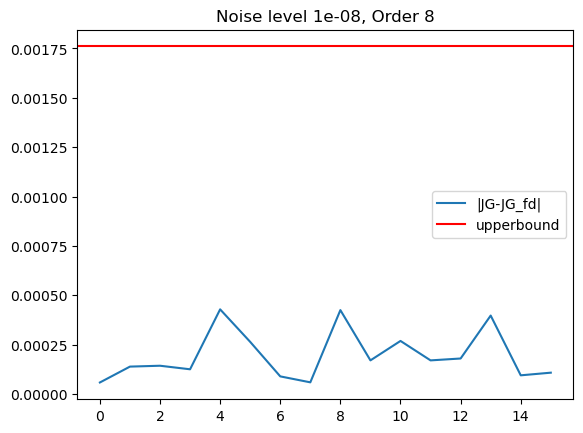

Noise level 1e-07
 |ut_fd - ut| 	= 3.279e-04 <= 5.599e-04
 |ux_fd - ux| 	= 2.585e-04 <= 4.479e-04
 |uxx_fd - uxx|	= 7.997e-03 <= 1.370e-02
 |utx_fd - utx|	= 3.478e-03 <= 1.143e-02
Upper bound 1.786e-02


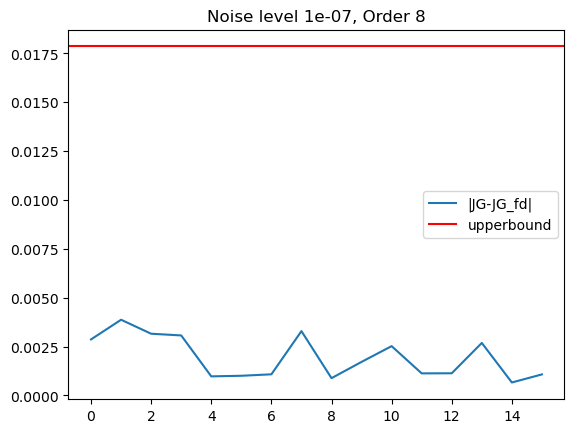

Noise level 1e-06
 |ut_fd - ut| 	= 2.618e-03 <= 5.676e-03
 |ux_fd - ux| 	= 2.541e-03 <= 4.541e-03
 |uxx_fd - uxx|	= 6.975e-02 <= 1.389e-01
 |utx_fd - utx|	= 3.367e-02 <= 1.159e-01
Upper bound 1.810e-01


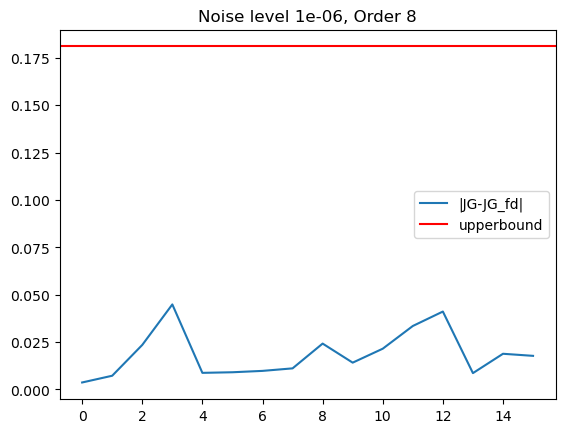

Noise level 1e-05
 |ut_fd - ut| 	= 3.406e-02 <= 5.505e-02
 |ux_fd - ux| 	= 2.863e-02 <= 4.404e-02
 |uxx_fd - uxx|	= 7.120e-01 <= 1.347e+00
 |utx_fd - utx|	= 3.536e-01 <= 1.124e+00
Upper bound 1.756e+00


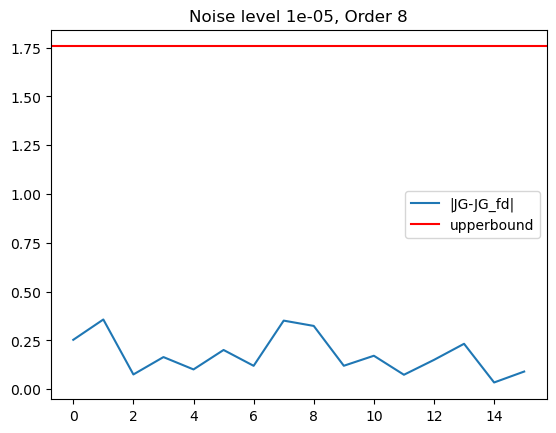

Noise level 0.0001
 |ut_fd - ut| 	= 2.996e-01 <= 4.974e-01
 |ux_fd - ux| 	= 2.085e-01 <= 3.980e-01
 |uxx_fd - uxx|	= 6.832e+00 <= 1.217e+01
 |utx_fd - utx|	= 3.440e+00 <= 1.016e+01
Upper bound 1.586e+01


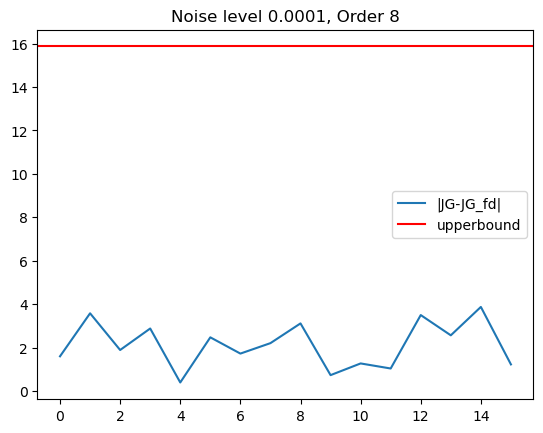

Noise level 0.001
 |ut_fd - ut| 	= 2.774e+00 <= 5.090e+00
 |ux_fd - ux| 	= 2.130e+00 <= 4.072e+00
 |uxx_fd - uxx|	= 7.238e+01 <= 1.245e+02
 |utx_fd - utx|	= 3.924e+01 <= 1.039e+02
Upper bound 1.623e+02


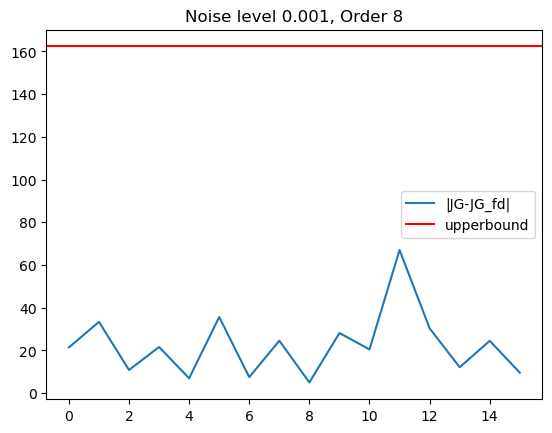

Noise level 0.01
 |ut_fd - ut| 	= 2.758e+01 <= 5.354e+01
 |ux_fd - ux| 	= 2.256e+01 <= 4.283e+01
 |uxx_fd - uxx|	= 6.755e+02 <= 1.310e+03
 |utx_fd - utx|	= 3.221e+02 <= 1.093e+03
Upper bound 1.707e+03


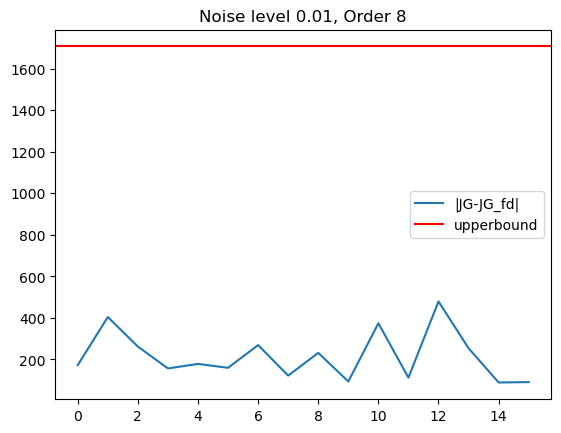

In [95]:
M=infinity_norm(u)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels: 
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    print(f"Noise level {noise_level}")
    #Calculate upper bounds
    eps = infinity_norm(u-u_noise)
    bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(a**(fd_order+1)*u),Cxi=1.0,h=dt)
    bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=infinity_norm(u),Cxi=1.0,h=dx)
    bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=infinity_norm(u),Cxi=1.0,h=dx)
    bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=infinity_norm(ut),Cxi=1.0,h=dx)
    
    #Calculate derivatives
    ut_fd, utx_fd,ux_fd, uxx_fd= get_derivatives(u_noise,dt,dx,fd_order)
    
    print(f" |ut_fd - ut| \t= {infinity_norm((ut_fd-ut).flatten()):.3e} <= {bound_ut:.3e}")
    print(f" |ux_fd - ux| \t= {infinity_norm((ux_fd-ux).flatten()):.3e} <= {bound_ux:.3e}")
    print(f" |uxx_fd - uxx|\t= {infinity_norm((uxx_fd-uxx).flatten()):.3e} <= {bound_uxx:.3e}")
    print(f" |utx_fd - utx|\t= {infinity_norm((utx_fd-utx).flatten()):.3e} <= {bound_utx:.3e}")
    
    jacobians =[]
    #Calculate upper bound which stays constant for all data points(only changes in noise level)
    nr_datapoints=1
    upperbound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)
    print(f"Upper bound {upperbound:.3e}")
    for i in range(space_range):
        for j in range(time_range):
            #Compute differenc between true Jacobian and finite difference Jacobian
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
            jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
            jacobian_diff = np.linalg.norm(jacobian_fd -jacobian)    
            jacobians.append(jacobian_diff)
    
            #print("Check wether upper bound is correct:")
            #print(f"|JG-JG_fd|= {jacobian_diff:.3e} <= {upperbound:.3e}")
    plt.title(f"Noise level {noise_level}, Order {fd_order}")
    plt.plot(jacobians,label="|JG-JG_fd|")
    plt.axhline(y=upperbound, color='r', linestyle='-',label="upperbound")
    plt.legend()
    filename = f"Images/noise_{noise_level}_order_{fd_order}.png"
    plt.savefig(filename)
    plt.show()

Compare Jacobians and singular values

In [76]:
def get_upper_bound_jacobian(eps,fd_order,Cut,Cux,Cuxx,Cutx,dt,dx,Cxi=1.0):

    bound_ut = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cut,Cxi=Cxi,h=dt)
    bound_ux = upper_bound_central_differences(eps,fd_order,order_derivative=1,Cu=Cux,Cxi=Cxi,h=dx)
    bound_uxx = upper_bound_central_differences(eps,fd_order,order_derivative=2,Cu=Cuxx,Cxi=Cxi,h=dx)
    bound_utx = upper_bound_central_differences(bound_ut,fd_order,order_derivative=1,Cu=Cutx,Cxi=Cxi,h=dx)

    upper_bound = np.sqrt(bound_ut**2+bound_ux**2 + bound_uxx**2+bound_utx**2)
    
    return upper_bound

In [78]:
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

#For saving results
svs = np.zeros([space_range, time_range])
svs_fd = np.zeros([space_range, time_range])
upper_bounds = np.zeros([space_range, time_range])
lower_bounds = np.zeros([space_range, time_range])


for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
        

        sv = svd(jacobian, compute_uv=False)
        sv_fd = svd(jacobian_fd, compute_uv=False)
        sv_min,sv_min_fd =sv[-1],sv_fd[-1]
        sv_max,sv_max_fd =sv[0],sv_fd[0]

        #Save the results 
        svs[i,j] = sv_min/sv_max
        svs_fd[i,j] =sv_min_fd/sv_max_fd
        jacobian_diff=np.linalg.norm(jacobian_fd -jacobian)
        upper_bound_jacobian = get_upper_bound_jacobian(1e-16,fd_order,infinity_norm(a**(fd_order+1)*u),
                                                        infinity_norm(u),infinity_norm(u),infinity_norm(ut),dt,dx)

        
        C1=sv_max
        C=sv_max
        C2=1e-4
        lower_bound = lower_bound_nonsingular_matrix(C1,C2,jacobian_diff)
        upper_bound = upper_bound_singular_matrix(C,jacobian_diff)

        lower_bound_nonexact = lower_bound_nonsingular_matrix(C1,C2,upper_bound_jacobian)
        upper_bound_nonexact = upper_bound_singular_matrix(C,upper_bound_jacobian)

        lower_bounds[i,j]=lower_bound
        upper_bounds[i,j]=upper_bound
        
        print(f" Comparison at x = {x_i}, t = {t_j} ")
        print(f" \t \t \t \t Original \t FD \t \t diff")
        print(f" Smallest singular values \t {sv_min:.3e}\t  {sv_min_fd:.3e} \t {np.abs(sv_min-sv_min_fd):.3e}")
        print(f" Biggest singular values \t {sv_max:.3e}\t  {sv_max_fd:.3e} \t {np.abs(sv_max-sv_max_fd):.3e}")
        print(f" Differences Jacobian \t \t {jacobian_diff:.3e} <= {upper_bound_jacobian:.3e}")
        print(" Bounds with jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound:.3e}")
        print(" Bounds with upper bound on jacobian difference")
        print(f" \t Lower bound for uniqueness: \t  {svs_fd[i,j]:.3e} >= {lower_bound_nonexact:.3e}")
        print(f" \t Upper bound for non uniqueness:  {svs_fd[i,j]:.3e} <= {upper_bound_nonexact:.3e}")
        print(f" True ratio: \t  \t \t  {svs[i,j]:.3e} ")

 Comparison at x = 10, t = 10 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 2.683e-02	  7.181e+00 	 7.154e+00
 Biggest singular values 	 3.668e+00	  1.076e+02 	 1.039e+02
 Differences Jacobian 	 	 1.057e+02 <= 7.831e-01
Bounds with jacobian difference
 	 Lower bound for uniqueness: 	  6.673e-02 >= 1.000e-10
 	 Upper bound for non uniqueness:  6.673e-02 <= 1.000e+00
Bounds with upper bound on jacobian difference
 	 Lower bound for uniqueness: 	  6.673e-02 >= 1.000e-10
 	 Upper bound for non uniqueness:  6.673e-02 <= 2.715e-01
 True ratio: 	  	 	  7.316e-03 
 Comparison at x = 10, t = 20 
 	 	 	 	 Original 	 FD 	 	 diff
 Smallest singular values 	 3.038e-02	  2.700e+00 	 2.670e+00
 Biggest singular values 	 4.153e+00	  7.077e+01 	 6.662e+01
 Differences Jacobian 	 	 7.311e+01 <= 7.831e-01
Bounds with jacobian difference
 	 Lower bound for uniqueness: 	  3.815e-02 >= 1.000e-10
 	 Upper bound for non uniqueness:  3.815e-02 <= 1.000e+00
Bounds with upper bound on jacobian dif

In [9]:
from matplotlib.colors import LinearSegmentedColormap
green=(100/255,250/255,100/255)#(0,1,0)
red=(241/255,13/255,30/255)
cmap_green_red = LinearSegmentedColormap.from_list('RedGreen', [green,red], N=256)
cmap_red_green = LinearSegmentedColormap.from_list('GreenRed', [red,green], N=256)

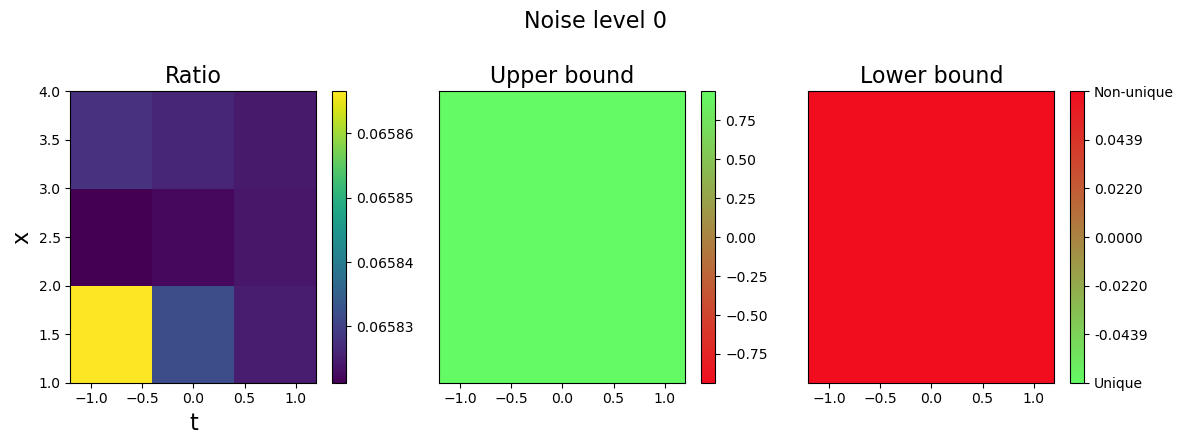

In [32]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
# Plot derivative results
subtitle_size=16
tickssize=16
order=fd_order
fig, axes = plt.subplots(1,3, figsize=(12,4))
plt.suptitle(f'Noise level 0', fontsize=subtitle_size,y=1.1)

#Plot the ratios
c = axes[0].pcolor(t_grid, x_grid, svs)
axes[0].set_title('Ratio', fontsize=tickssize)
axes[0].set_ylabel('x', fontsize=tickssize)
axes[0].set_xlabel('t', fontsize=tickssize)
fig.colorbar(c, ax=axes[0])

upper_minus_svs = upper_bounds - svs
lower_minus_svs = svs-lower_bounds
max_svs= np.max(np.abs(upper_minus_svs))
#Plot difference to upper bound

axes[1].set_title('Upper bound', fontsize=tickssize)
c=axes[1].pcolor(t_grid, x_grid, upper_minus_svs,cmap=cmap_red_green,vmin=-max_svs, vmax=max_svs)
axes[1].set_yticks([])
fig.colorbar(c, ax=axes[1])

#Plot difference to lower bound
lower_minus_svs = svs-lower_bounds
max_svs= np.max(np.abs(lower_minus_svs))
axes[2].set_title('Lower bound', fontsize=tickssize)
c = axes[2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_green_red, vmin=-max_svs, vmax=max_svs)
axes[2].set_yticks([])
cb = fig.colorbar(c, ax=axes[2])
ticks=np.linspace(-max_svs, max_svs,7) 
cb.set_ticks(ticks)
cb.set_ticklabels(['Unique', f'{ticks[1]:.4f}',f'{ticks[2]:.4f}',f'{ticks[3]:.4f}', f'{ticks[4]:.4f}', f'{ticks[5]:.4f}', 'Non-unique'])
plt.tight_layout()

### Different noise levels

In [99]:
def plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,subtitle="",subtitle_size=16,tickssize=16):
    t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    #Plot the ratios
    c = axes[0].pcolor(t_grid, x_grid, svs)
    axes[0].set_title('Ratio', fontsize=tickssize)
    axes[0].set_ylabel('x', fontsize=tickssize)
    axes[0].set_xlabel('t', fontsize=tickssize)
    fig.colorbar(c, ax=axes[0])
    
    upper_minus_svs = upper_bounds - svs
    lower_minus_svs = svs-lower_bounds
    max_svs= np.max(np.abs(upper_minus_svs))
    #Plot difference to upper bound
    plt.suptitle(subtitle, fontsize=subtitle_size,y=1.1)
    
    axes[1].set_title('Upper bound', fontsize=tickssize)
    c=axes[1].pcolor(t_grid, x_grid, upper_minus_svs,cmap=cmap_red_green,vmin=-max_svs, vmax=max_svs)
    axes[1].set_yticks([])
    fig.colorbar(c, ax=axes[1])
    
    #Plot difference to lower bound
    lower_minus_svs = svs-lower_bounds
    max_svs= np.max(np.abs(lower_minus_svs))
    axes[2].set_title('Lower bound', fontsize=tickssize)
    c = axes[2].pcolor(t_grid, x_grid, lower_minus_svs, cmap=cmap_green_red, vmin=-max_svs, vmax=max_svs)
    axes[2].set_yticks([])
    cb = fig.colorbar(c, ax=axes[2])
    ticks=np.linspace(-max_svs, max_svs,7) 
    cb.set_ticks(ticks)
    cb.set_ticklabels(['Unique', f'{ticks[1]:.4f}',f'{ticks[2]:.4f}',f'{ticks[3]:.4f}', f'{ticks[4]:.4f}', f'{ticks[5]:.4f}', 'Non-unique'])
    #plt.savefig(f"Images/JRC_{subtitle}")
    plt.tight_layout()
    


In [100]:
def get_results(space_range,time_range,u,fd_order,dt,dx,eps):
    
    ut_fd, utx_fd,ux_fd, uxx_fd= get_derivatives(u,dt,dx,fd_order)
    #For saving results
    svs = np.zeros([space_range, time_range])
    upper_bounds = np.zeros([space_range, time_range])
    lower_bounds = np.zeros([space_range, time_range])  
    
    for i in range(space_range):
        for j in range(time_range):
            x_i, t_j = i * 10 + 10, j * 10 + 10
            jacobian_fd = np.array([[ut_fd[x_i,t_j], ux_fd[x_i,t_j]], [utx_fd[x_i,t_j], uxx_fd[x_i,t_j]]]).reshape(2,2)
            
            sv_fd = svd(jacobian_fd, compute_uv=False)
            sv_min =sv_fd[-1]
            sv_max =sv_fd[0]
    
            #Save the results 
            svs[i,j] = sv_min/sv_max
            C1=sv_max*1.5
            C=sv_max*0.5
            C2=max(1e-4,sv_min*0.5)

            upper_bound_jacobian = get_upper_bound_jacobian(eps,fd_order,infinity_norm(a**(fd_order+1)*u),
                                                infinity_norm(u),infinity_norm(u),infinity_norm(ut),dt,dx)
            
            lower_bound = lower_bound_nonsingular_matrix(C1,C2,upper_bound_jacobian)
            upper_bound = upper_bound_singular_matrix(C,upper_bound_jacobian)

            lower_bounds[i,j]=lower_bound
            upper_bounds[i,j]=upper_bound
    return svs, lower_bounds,upper_bounds

Noise level 0
Noise level 1e-10
Noise level 1e-09
Noise level 1e-08
Noise level 1e-07
Noise level 1e-06
Noise level 1e-05
Noise level 0.0001
Noise level 0.001
Noise level 0.01


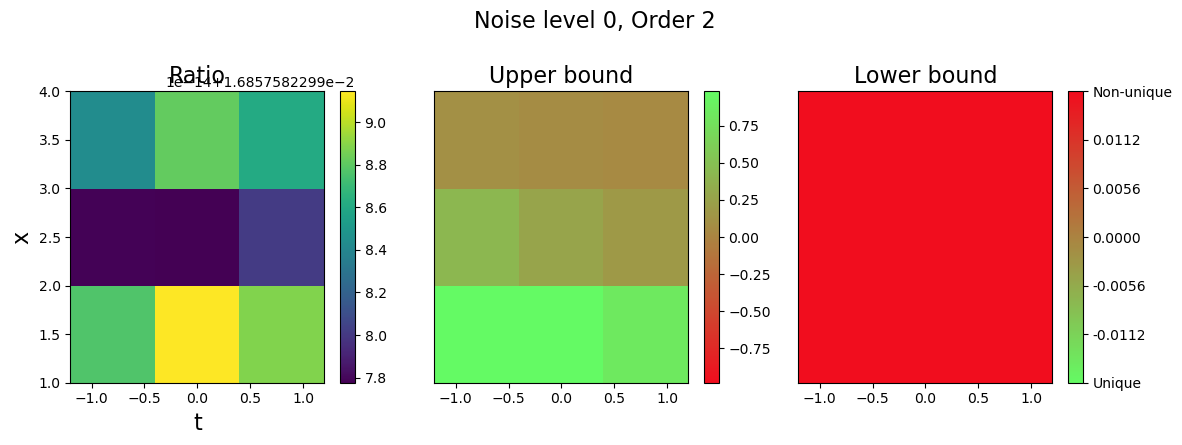

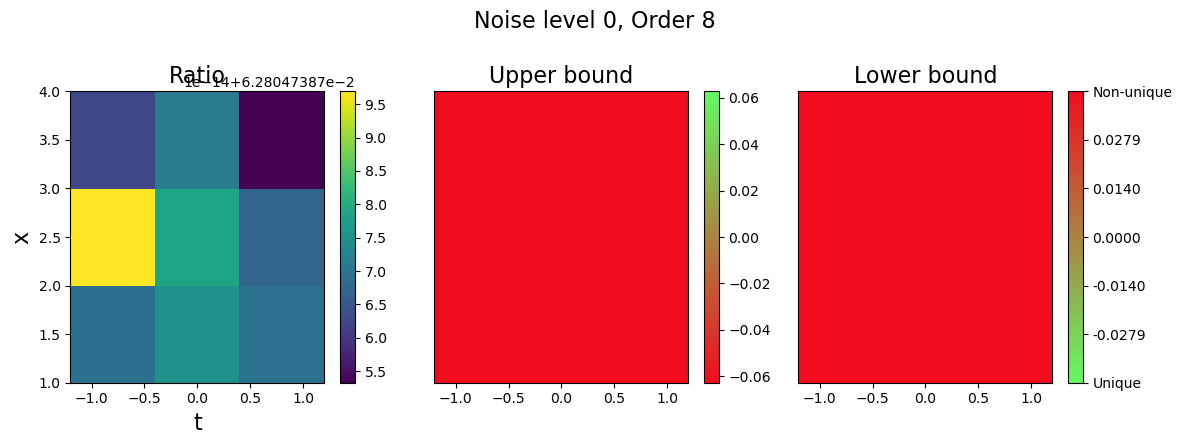

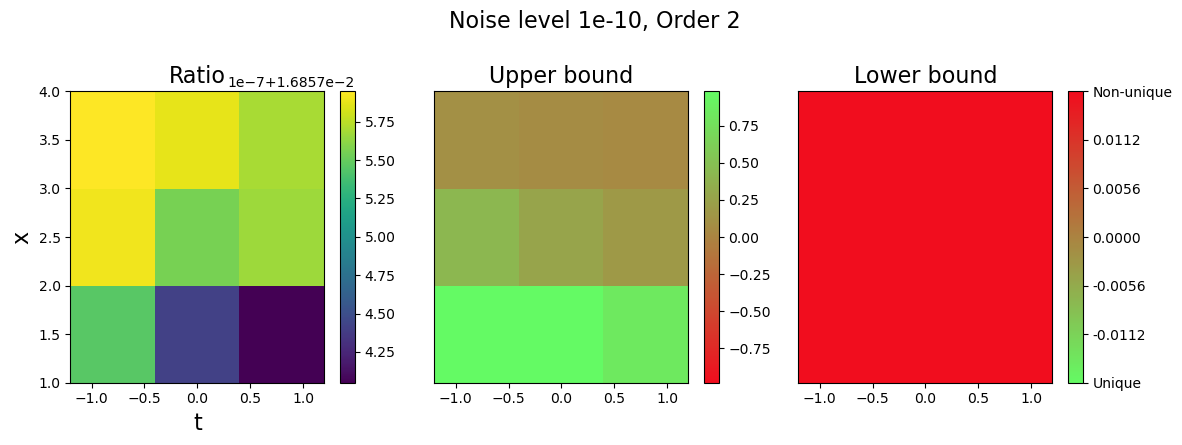

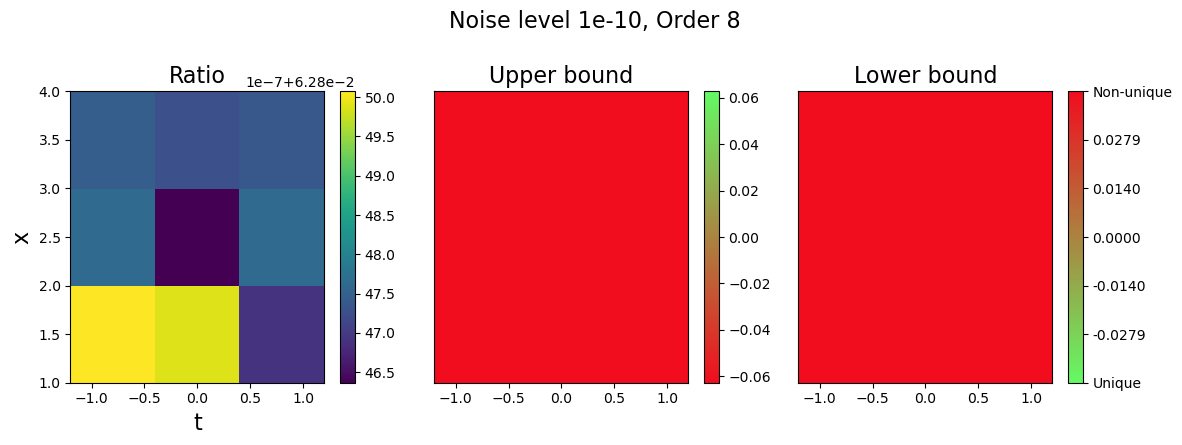

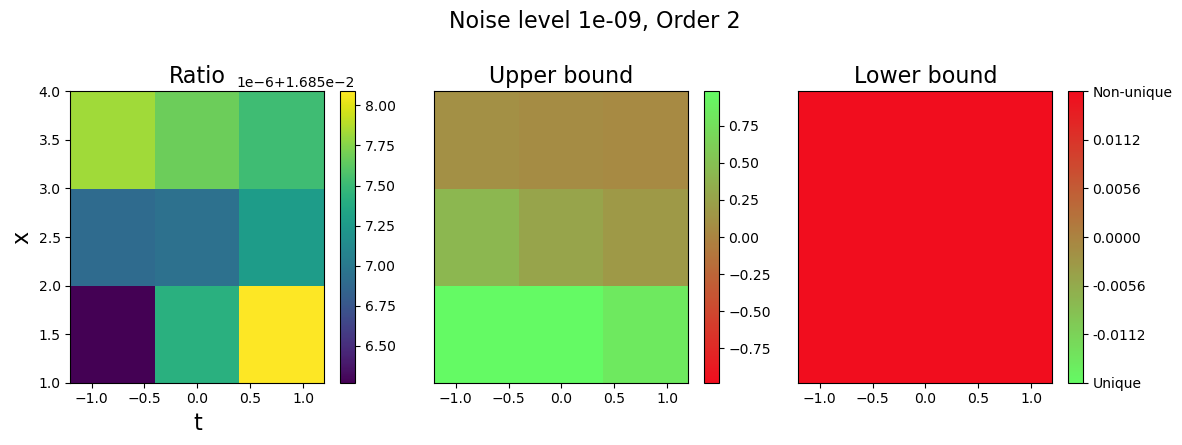

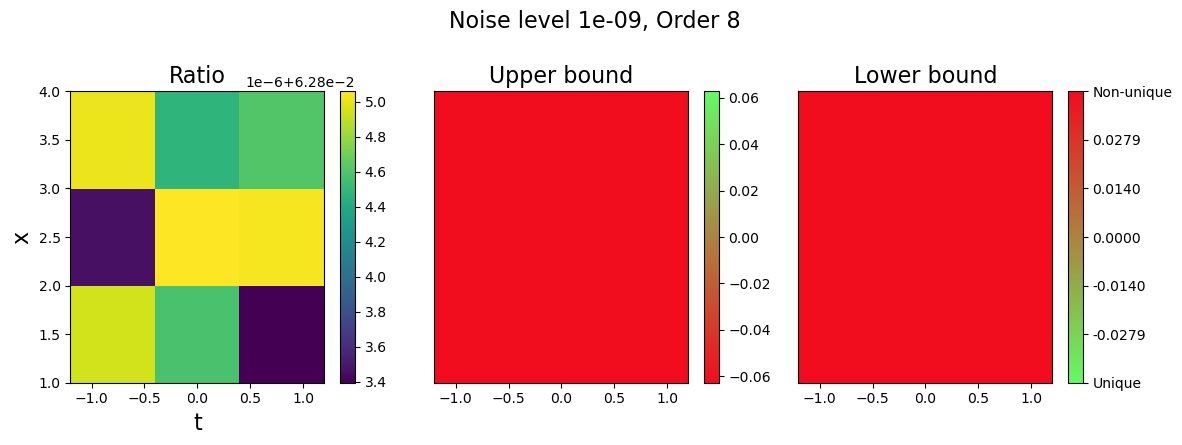

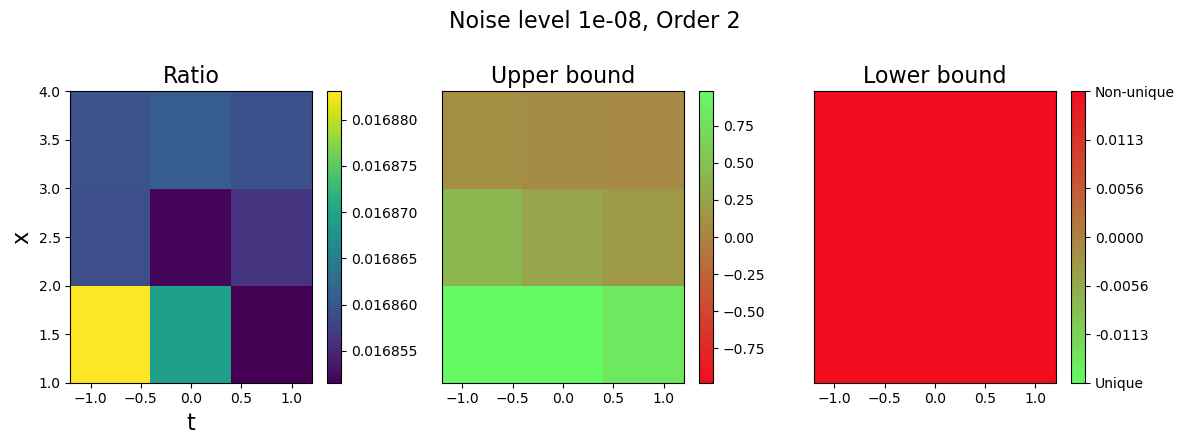

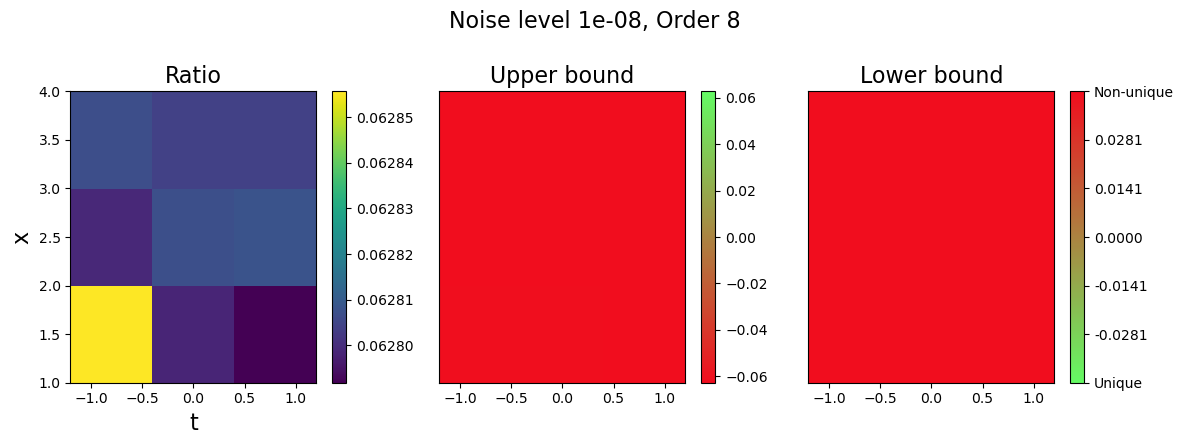

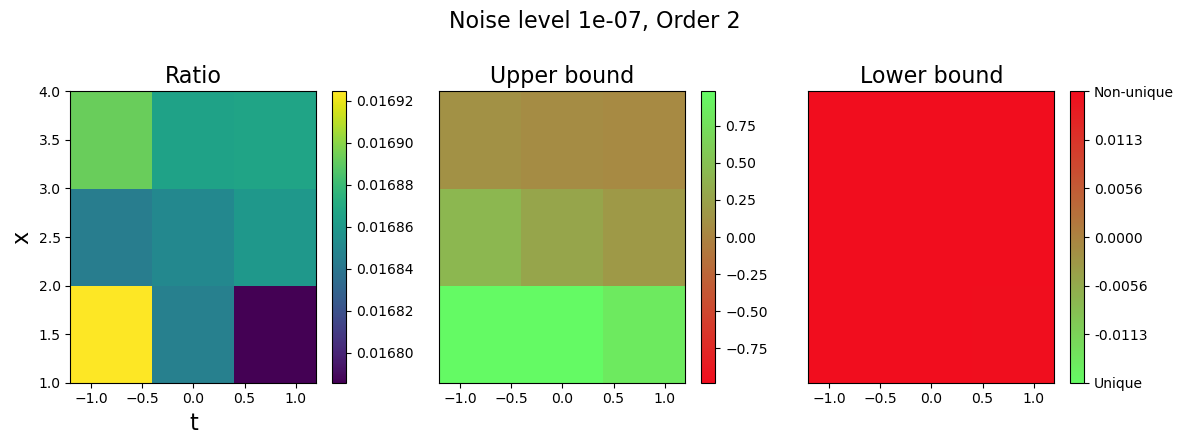

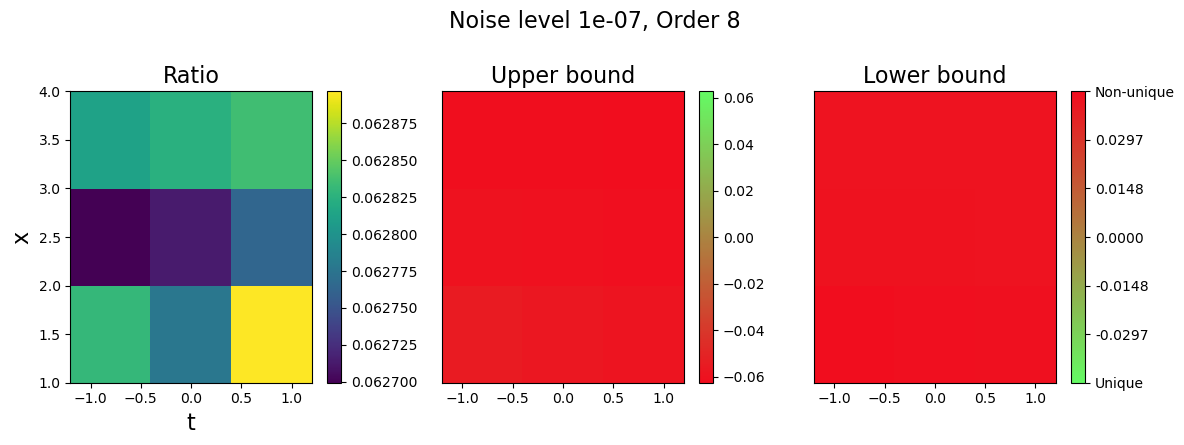

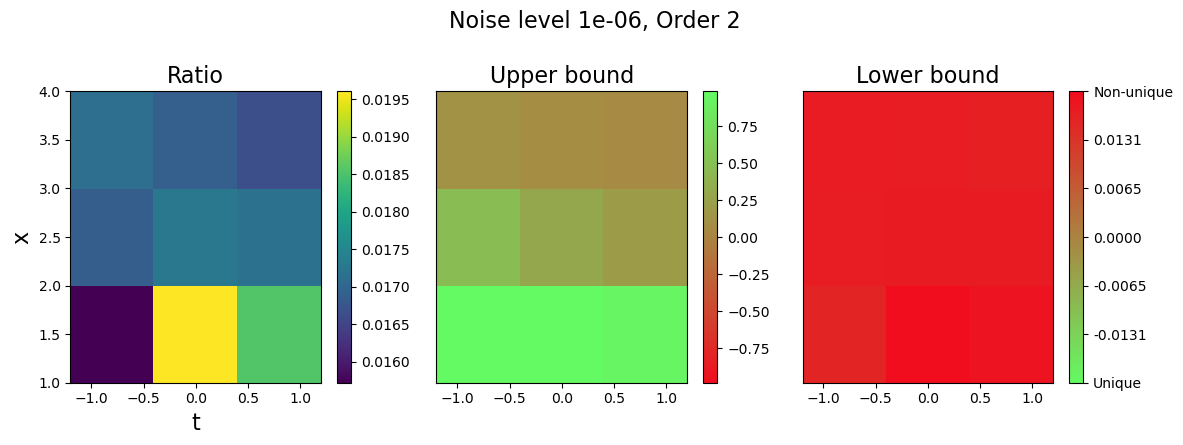

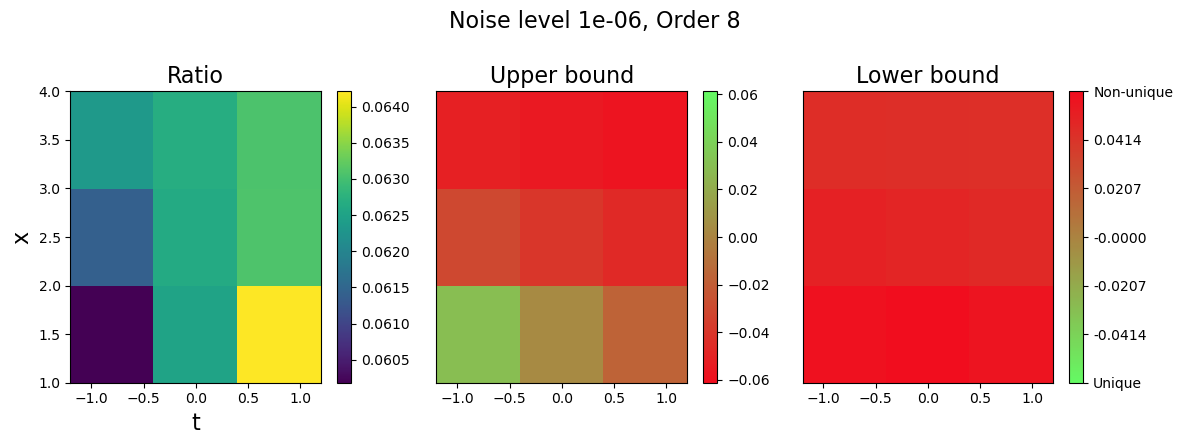

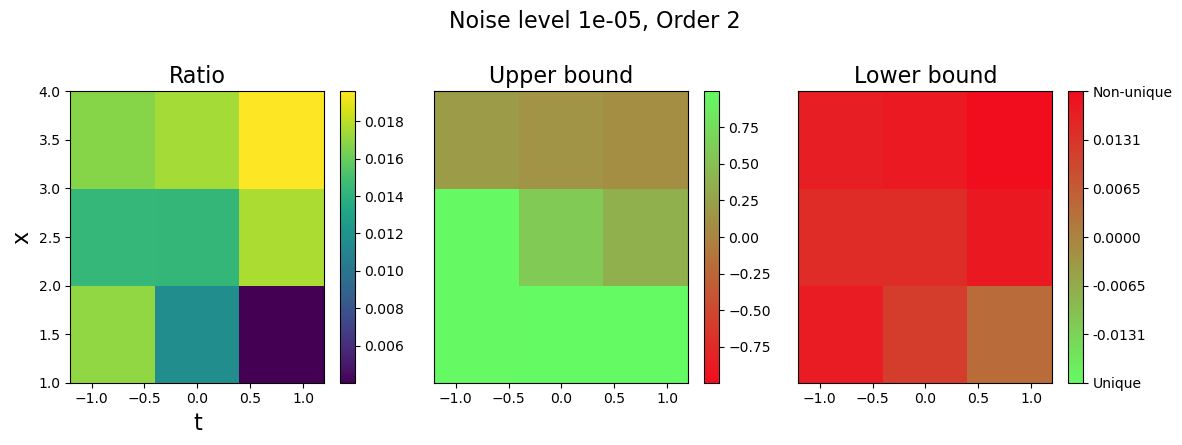

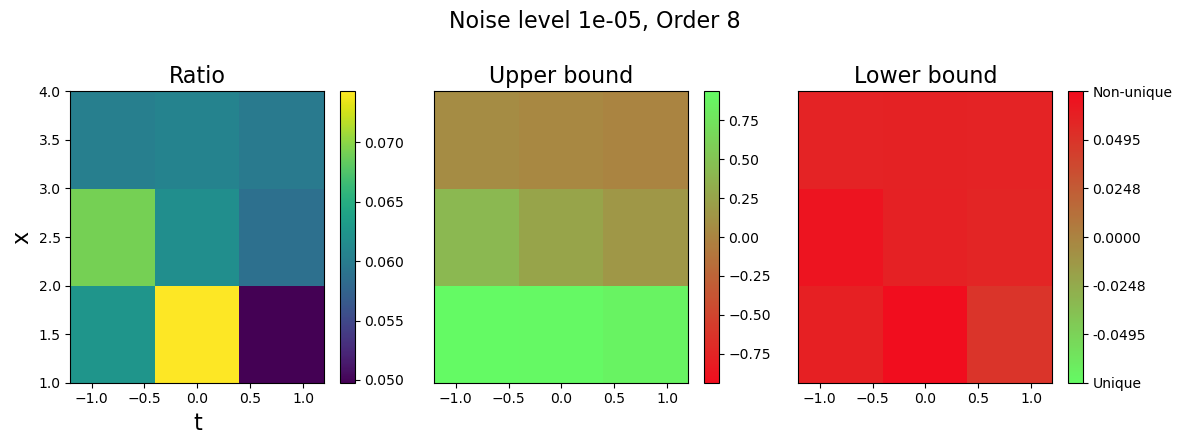

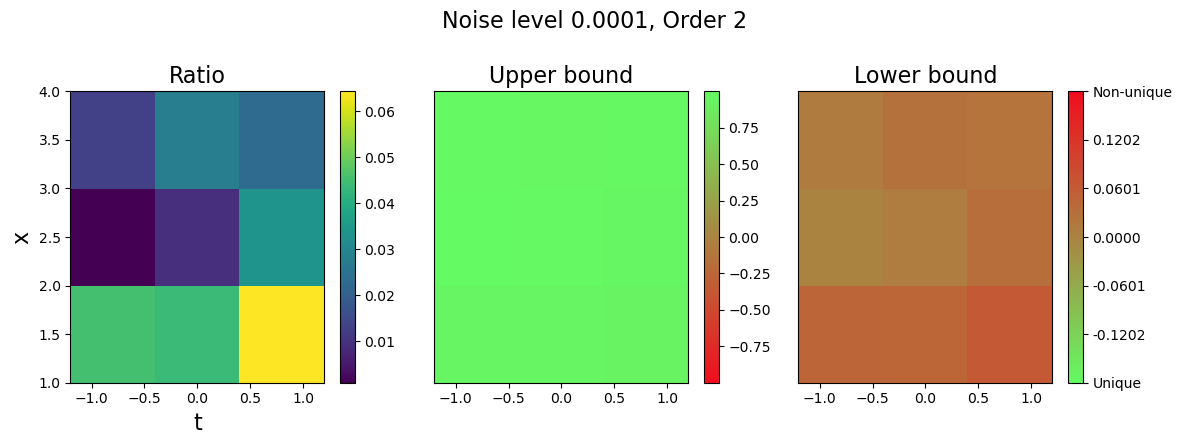

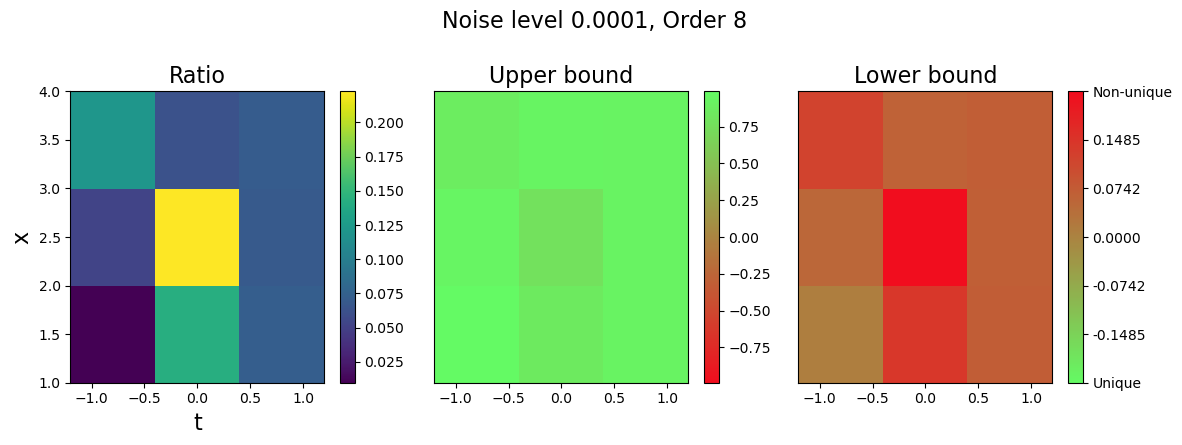

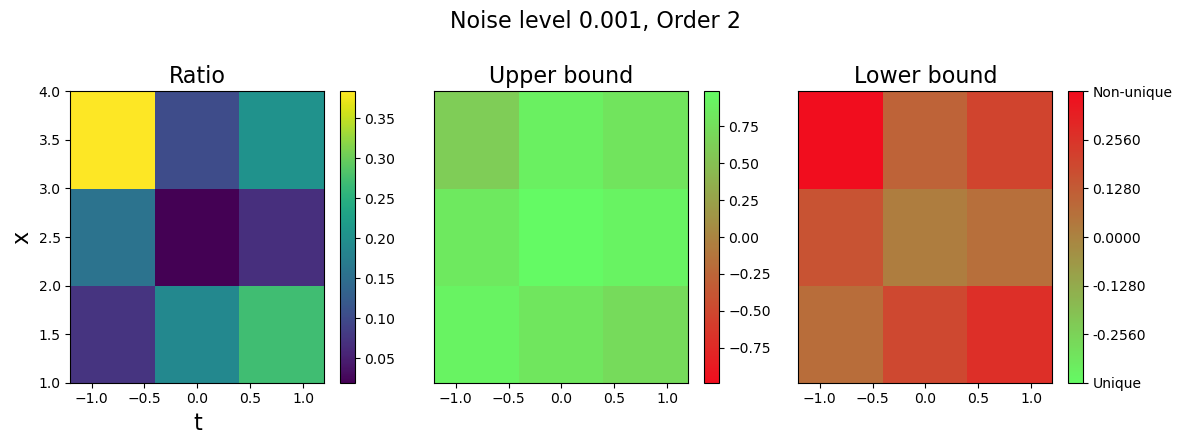

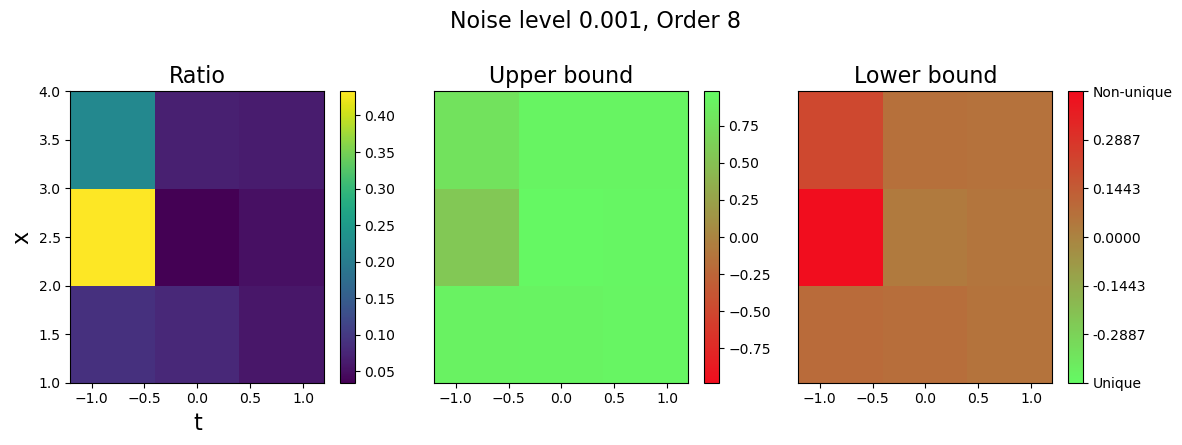

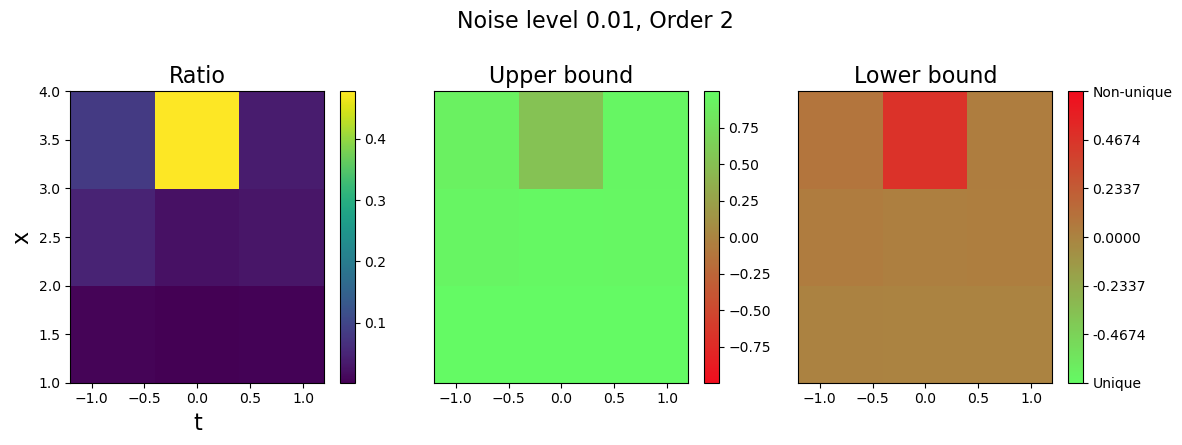

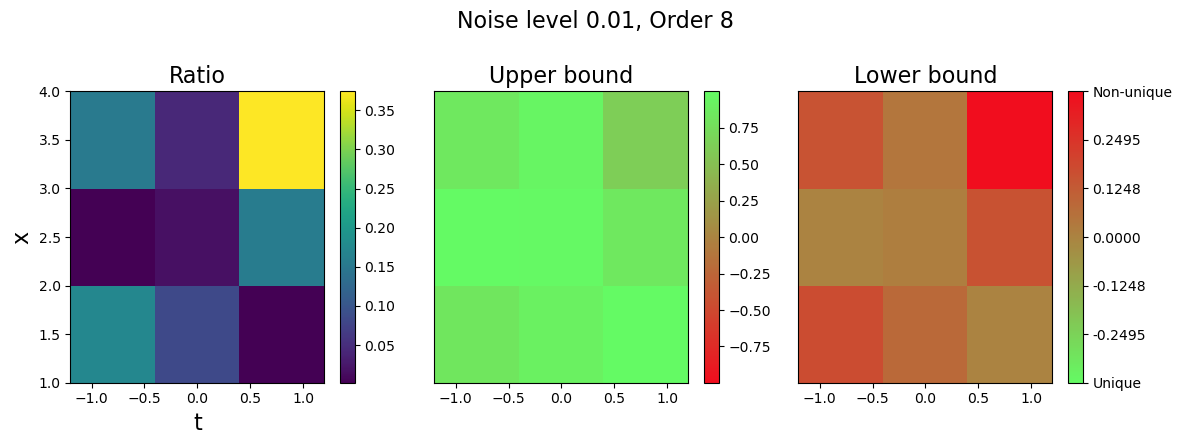

In [101]:
M=infinity_norm(u)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,2)
unorm2=np.sqrt(np.mean(np.square(u)))

for noise_level in noise_levels:    
    
    var = noise_level * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    eps = infinity_norm(u-u_noise)
    
    print(f"Noise level {noise_level}")
    fd_orders=(2,8)
    svs, lower_bounds,upper_bounds = get_results(space_range,time_range,u_noise,fd_orders[0],dt,dx,eps)
    plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,subtitle=f"Noise level {noise_level}, Order {fd_orders[0]}")
    svs, lower_bounds,upper_bounds = get_results(space_range,time_range,u_noise,fd_orders[1],dt,dx,eps)
    plot_results(upper_bounds, lower_bounds,svs,time_range,space_range,subtitle=f"Noise level {noise_level}, Order {fd_orders[1]}")

### Try it on different examples